<a href="https://www.kaggle.com/code/yosefibrahim/sentiment-analysis-using-bert-and-transformers?scriptVersionId=168554074" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [234]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-airline-sentiment/Tweets.csv
/kaggle/input/twitter-airline-sentiment/database.sqlite


In [1]:
!nvidia-smi

Sun Mar 24 11:37:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install -q transformers
!pip install datasets
!pip install evaluate
!pip install rouge-score
!pip install py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=b62bdbf26cfcf148d7c6bb4f1d045cb863ca2a14cb49c06d559176bcfae633a1
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 64.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 25.4 MB/s eta 0:00:00
  Attempting uninstall: brot

In [3]:
# Importing Libraries

# Data Handling
import pandas as pd
import numpy as np
from datasets import Dataset, load_metric
import shutil
from collections import defaultdict

# Data Visualization
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as sp
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.io as pio
from IPython.display import display
from plotly.offline import init_notebook_mode
import matplotlib.pyplot as plt
import seaborn as sns
init_notebook_mode(connected=True)

# Statistics & Mathematics
import scipy.stats as stats
import statsmodels.api as sm
from wordcloud import WordCloud, STOPWORDS
from scipy.stats import shapiro, skew, anderson, kstest, gaussian_kde,spearmanr
import math

# Transformers
import tensorflow as tf
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax
from transformers import BartTokenizer, BartForConditionalGeneration      # BERT Tokenizer and architecture
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments         # These will help us to fine-tune our model
from transformers import pipeline                                         # Pipeline
from transformers import DataCollatorForSeq2Seq                           # DataCollator to batch the data 
import torch                                                              # PyTorch
import evaluate                                                           # Hugging Face's library for model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch import nn, optim

import time
import datetime
import gc
import random
from nltk.corpus import stopwords

import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import transformers
from transformers import BertForSequenceClassification, AdamW, BertConfig,BertTokenizer,get_linear_schedule_with_warmup


# Other NLP libraries
from textblob import TextBlob                                             # This is going to help us fix spelling mistakes in texts
from sklearn.feature_extraction.text import TfidfVectorizer               # This is going to helps identify the most common terms in the corpus
import re                                                                 # This library allows us to clean text data
import nltk                                                               # Natural Language Toolkit
nltk.download('punkt') 


# Hiding warnings
import warnings
warnings.filterwarnings("ignore")

2024-03-24 11:40:44.499757: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 11:40:44.499857: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 11:40:44.687550: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:
df =pd.read_csv(r'../input/twitter-airline-sentiment/Tweets.csv')
#df = df[['airline_sentiment','text']]
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [11]:
df['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [12]:
df['airline'].unique()

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways',
       'American'], dtype=object)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [14]:
df.isna().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [15]:
airlines=['@VirginAmerica', '@United', '@Southwest', '@Delta', '@USAirways',
       '@American']

In [16]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if (t.startswith('@') and len(t) > 1 and t not in airlines) else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [17]:
columnsTodrob=["negativereason","negativereason_confidence","airline_sentiment_gold","negativereason_gold","tweet_coord"\
              ,"tweet_location","user_timezone"]

In [18]:
df = df.drop(columns=columnsTodrob)

In [19]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_created
0,570306133677760513,neutral,1.0000,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800
1,570301130888122368,positive,0.3486,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800
2,570301083672813571,neutral,0.6837,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800
3,570301031407624196,negative,1.0000,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800
4,570300817074462722,negative,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800


In [20]:
df['text'].apply(lambda x:len(x.split(' '))).max()

36

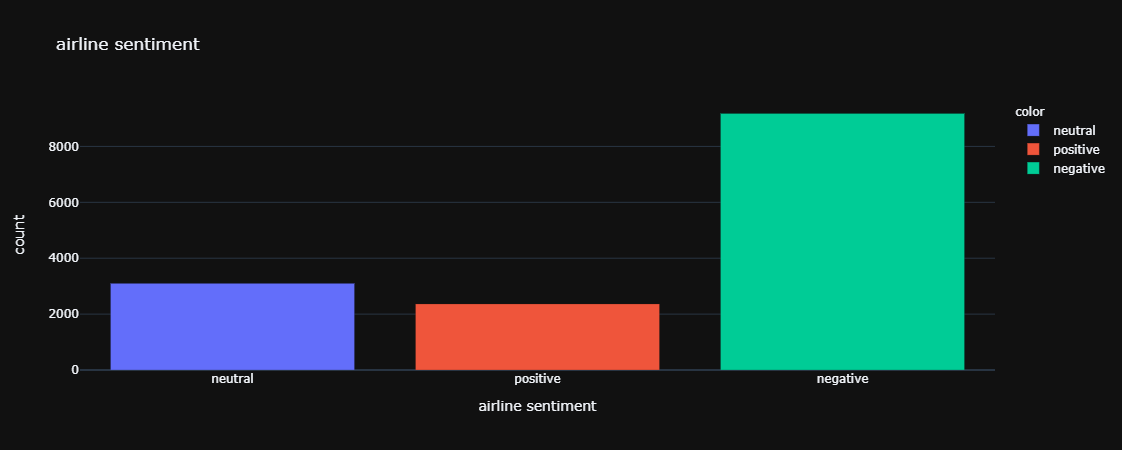

In [21]:
fig = px.histogram(
    df["airline_sentiment"], 
    nbins=25,
    title= "airline sentiment",
    template="plotly_dark",
    labels={"value" :"airline sentiment"},
    color=df["airline_sentiment"]
)
fig.update_traces(
    textfont = {
        "size" : 20,
        "family" :"tahoma",
        "color": "#fff"
    },
    hovertemplate = "airline sentiment: %{x}<br>Frequency: %{y}",
    marker=dict(line=dict(color='#000', width=0.1))
)

fig.show()

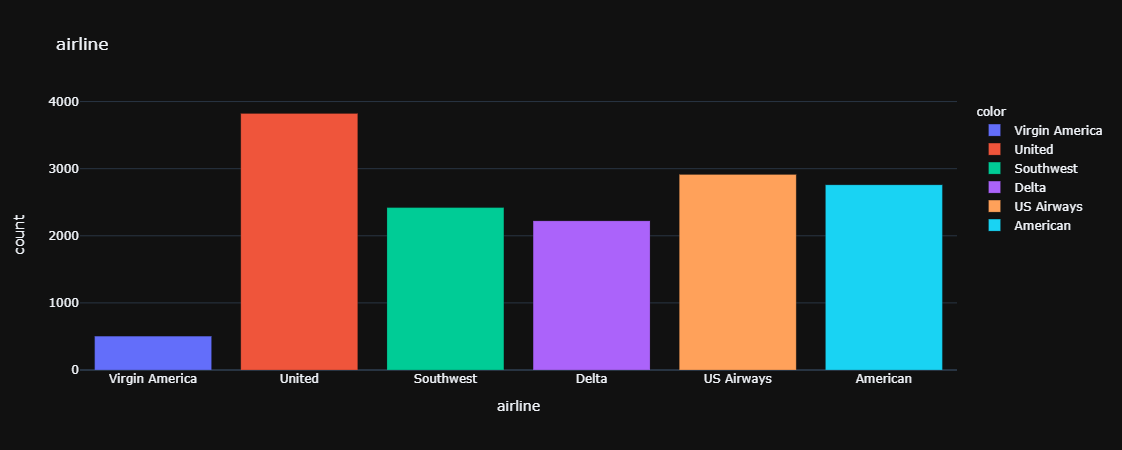

In [22]:
fig = px.histogram(
    df["airline"], 
    nbins=25,
    title= "airline",
    template="plotly_dark",
    labels={"value" :"airline"},
    color=df["airline"]
)
fig.update_traces(
    textfont = {
        "size" : 20,
        "family" :"tahoma",
        "color": "#fff"
    },
    hovertemplate = "airline: %{x}<br>Frequency: %{y}",
    marker=dict(line=dict(color='#000', width=0.1))
)

fig.show()

In [23]:
senline=df[['airline_sentiment', 'airline']].groupby(['airline_sentiment'], as_index=False).value_counts().sort_values(by='airline', ascending=False)

In [24]:
senline.head()

,airline_sentiment,airline,count
17,positive,Virgin America,152
5,negative,Virgin America,181
11,neutral,Virgin America,171
14,positive,United,492
7,neutral,United,697


In [25]:
def clean_tags(text):
    text=preprocess(text)
    clean = re.compile('<.*?>') # Compiling tags
    clean = re.sub(clean, '', text) # Replacing tags text by an empty string
    
    # Removing empty dialogues
    clean = '\n'.join([line for line in clean.split('\n') if not re.match('.*:\s*$', line)])

    return clean

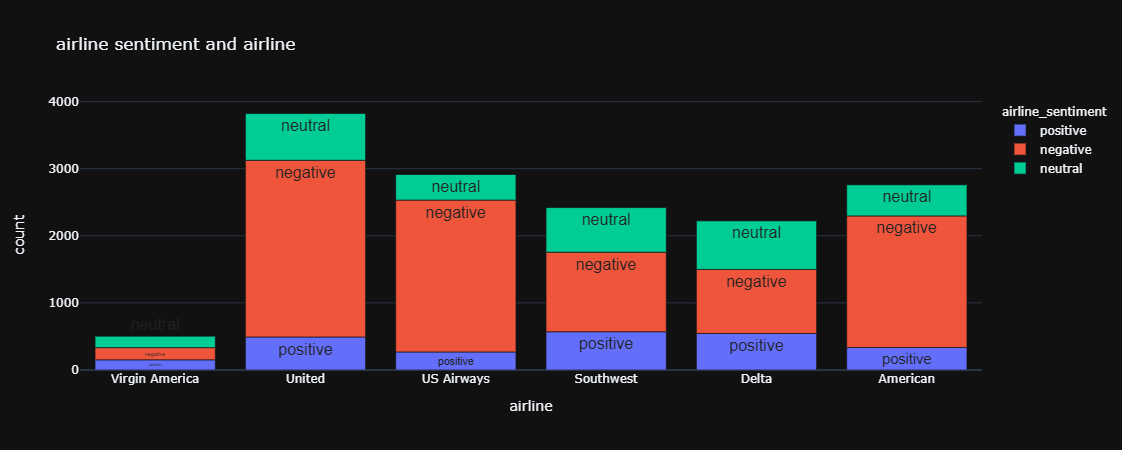

In [26]:
fig = px.bar(data_frame = senline,
             x = senline['airline'],
             y = senline['count'],
             color = senline['airline_sentiment'],
             title = "airline sentiment and airline",
             #color_discrete_sequence=["#45FFCA", "#D09CFA", "#FF9B9B"],
             labels= {"index" :"sentiment", "y": "airline in PCT(%)"},
             template="plotly_dark",
             text = senline['airline_sentiment']
            )


fig.update_traces(
    textfont = {
        "size" : 16,
        "family" :"arial",
        "color": "#222"
    },
    hovertemplate = "sentiment: %{x}<br>airline: %{y}",
)

fig.show()

In [360]:
#df = df[df['airline_sentiment']!='neutral']

In [27]:
senline=df[['airline_sentiment', 'airline']].groupby(['airline_sentiment'], as_index=False).value_counts().sort_values(by='airline', ascending=False)

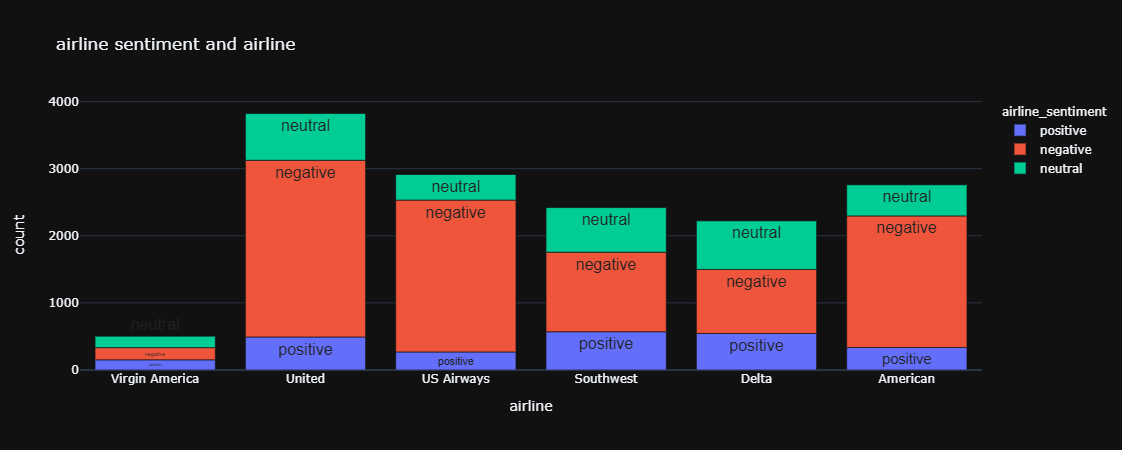

In [28]:
fig = px.bar(data_frame = senline,
             x = senline['airline'],
             y = senline['count'],
             color = senline['airline_sentiment'],
             title = "airline sentiment and airline",
             #color_discrete_sequence=["#45FFCA", "#D09CFA", "#FF9B9B"],
             labels= {"index" :"sentiment", "y": "airline in PCT(%)"},
             template="plotly_dark",
             text = senline['airline_sentiment']
            )


fig.update_traces(
    textfont = {
        "size" : 16,
        "family" :"arial",
        "color": "#222"
    },
    hovertemplate = "sentiment: %{x}<br>airline: %{y}",
)

fig.show()

In [29]:
def generate_wordcloud(text,Title):
    all_text = " ".join(text)
    wordcloud = WordCloud(width=800, 
                          height=400,
                          stopwords=set(STOPWORDS), 
                          background_color='black').generate(all_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(Title)
    plt.show()

In [30]:
'''sent={"negative":0,
     "positive":1}'''
sent={"negative":0,
     "positive":2,
     "neutral":1}
df['airline_sentiment_encodded']=df["airline_sentiment"].map(sent)

In [31]:
df["cleaned_text"]=df["text"].apply(clean_tags)

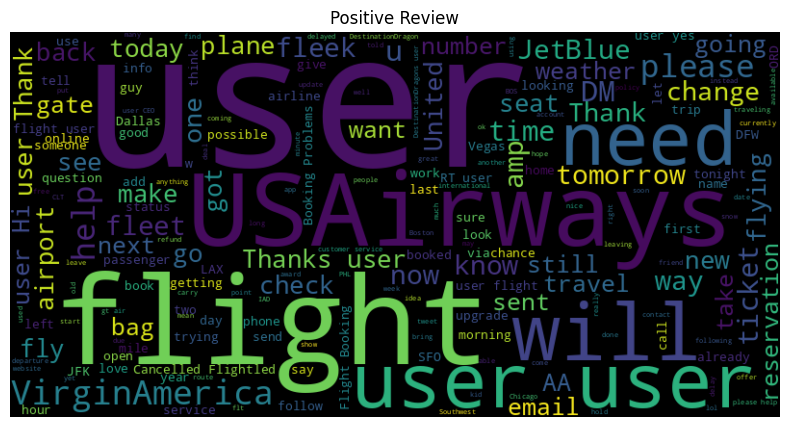

In [32]:
positive = df[df['airline_sentiment_encodded']==1]['cleaned_text'].tolist()
generate_wordcloud(positive,'Positive Review')

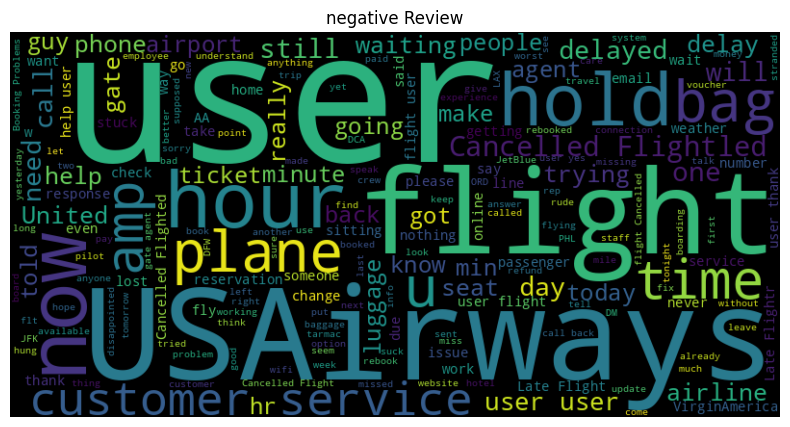

In [33]:
negative = df[df['airline_sentiment_encodded']==0]['cleaned_text'].tolist()
generate_wordcloud(negative,'negative Review')

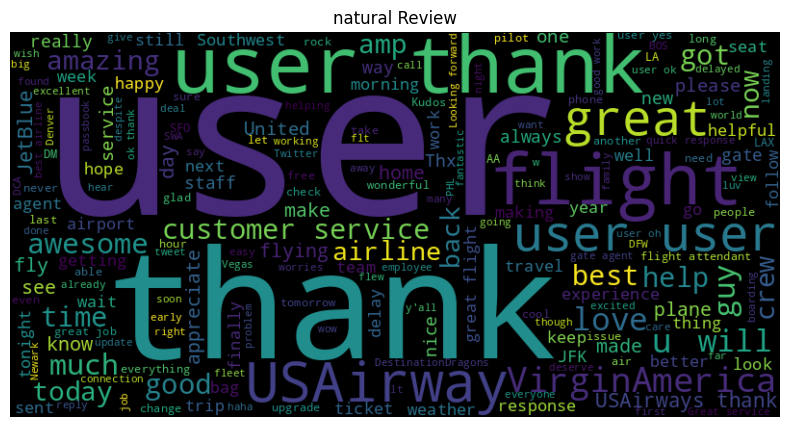

In [35]:
natural = df[df['airline_sentiment_encodded']==2]['cleaned_text'].tolist()
generate_wordcloud(natural,'natural Review')

In [36]:
test1 = clean_tags(df['text'].iloc[50]) # Applying function to example text

# Printing results
print(test1)

@VirginAmerica Is flight 769 on it's way? Was supposed to take off 30 minutes ago. Website still shows "On Time" not "In Flight". Thanks.


In [37]:
df.airline_sentiment_encodded.value_counts()

airline_sentiment_encodded
0    9178
1    3099
2    2363
Name: count, dtype: int64

In [38]:
df1=df[["cleaned_text","airline_sentiment_encodded"]].reset_index()

In [47]:
df1.head()

,index,cleaned_text,airline_sentiment_encodded
0,0,@VirginAmerica What @user said.,1
1,1,@VirginAmerica plus you've added commercials t...,2
2,2,@VirginAmerica I didn't today... Must mean I n...,1
3,3,@VirginAmerica it's really aggressive to blast...,0
4,4,@VirginAmerica and it's a really big bad thing...,0


In [45]:
x=df1["cleaned_text"]
y=df1["airline_sentiment_encodded"]

In [46]:
x.head()

0                      @VirginAmerica What @user said.
1    @VirginAmerica plus you've added commercials t...
2    @VirginAmerica I didn't today... Must mean I n...
3    @VirginAmerica it's really aggressive to blast...
4    @VirginAmerica and it's a really big bad thing...
Name: cleaned_text, dtype: object

In [48]:
sw = stopwords.words('english')

def clean_text(text):
    
    text = text.lower()
    
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub(r"http\S+", "",text) #Removing URLs 
    #text = re.sub(r"http", "",text)
    
    html=re.compile(r'<.*?>') 
    
    text = html.sub(r'',text) #Removing html tags
    
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations
        
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    
    text = " ".join(text) #removing stopwords
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Removing emojis
    
    return text

In [49]:
df1['cleaned_text'] = df1['cleaned_text'].apply(lambda x: clean_text(x))

In [94]:
train_df,test_df= train_test_split(df1, test_size=0.1, random_state=90,shuffle=False)

In [97]:
tweets = train_df.cleaned_text.values
labels = train_df['airline_sentiment_encodded'].values

In [98]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [99]:
print(' Original: ', tweets[5])
print()
# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(tweets[5]))
print()
# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(tweets[5])))

 Original:  virginamerica seriously would pay flight seats playing really bad thing flying va

Tokenized:  ['virgin', '##ame', '##rica', 'seriously', 'would', 'pay', 'flight', 'seats', 'playing', 'really', 'bad', 'thing', 'flying', 'va']

Token IDs:  [6261, 14074, 14735, 5667, 2052, 3477, 3462, 4272, 2652, 2428, 2919, 2518, 3909, 12436]


In [100]:
max_len = 0

# For every sentence...
for sent in tweets:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  44


In [101]:
input_ids = []
attention_masks = []

# For every tweet...
for tweet in tweets:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        tweet,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', tweets[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  virginamerica user said
Token IDs: tensor([  101,  6261, 14074, 14735,  5310,  2056,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [75]:
# # Calculate the number of samples to include in each set.
# train_size = int(0.8 * len(dataset))
# val_size = int(0.15 * len(dataset))
# # val_size = len(dataset)  - train_size
# # val_size = val_size  - train_size
# test_size = int(0.05 * len(dataset))
# val_size,train_size,test_size,len(dataset)

(2196, 11712, 732, 14640)

In [103]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
# val_size = int(0.2 * len(dataset))
val_size = len(dataset)  - train_size
# test_size = int(0.05 * len(dataset))

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
# val_size = int(0.7 * len(val_dataset))
# test_size = len(val_dataset)  - val_size
# val_dataset, test_dataset= random_split(val_dataset, [val_size, test_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
# print('{:>5,} test samples'.format(test_size))

10,540 training samples
2,636 validation samples


In [106]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [107]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# if device == "cuda:0":
# # Tell pytorch to run this model on the GPU.
#     model = model.cuda()
model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [108]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [109]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [110]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [111]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [112]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the device using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)        
        loss = output.loss
        total_train_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    # Tracking variables 
    total_eval_accuracy = 0
    best_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            output= model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = output.loss
        total_eval_loss += loss.item()
        # Move logits and labels to CPU if we are using GPU
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    if avg_val_accuracy > best_eval_accuracy:
        torch.save(model, 'bert_model')
        best_eval_accuracy = avg_val_accuracy
    #print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    #print("  Validation took: {:}".format(validation_time))
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.64
  Training epcoh took: 0:01:15

Running Validation...
  Accuracy: 0.78

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.44
  Training epcoh took: 0:01:18

Running Validation...
  Accuracy: 0.79

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.34
  Training epcoh took: 0:01:20

Running Validation...
  Accuracy: 0.79

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.26
  Training epcoh took: 0:01:20

Running Validation...
  Accuracy: 0.79

Training complete!
Total training took 0:05:43 (h:mm:ss)


In [113]:
model = torch.load('bert_model')

In [115]:
test_tweets = test_df['cleaned_text'].values

In [116]:
test_input_ids = []
test_attention_masks = []
for tweet in test_tweets:
    encoded_dict = tokenizer.encode_plus(
                        tweet,                     
                        add_special_tokens = True, 
                        max_length = max_len,           
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    test_input_ids.append(encoded_dict['input_ids'])
    test_attention_masks.append(encoded_dict['attention_mask'])
test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)

In [117]:
test_dataset = TensorDataset(test_input_ids, test_attention_masks)
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [118]:
predictions = []
for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        with torch.no_grad():        
            output= model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask)
            logits = output.logits
            logits = logits.detach().cpu().numpy()
            pred_flat = np.argmax(logits, axis=1).flatten()
            
            predictions.extend(list(pred_flat))

In [119]:
df_output = pd.DataFrame()
#df_output['id'] = df_test['id']
df_output['target'] =predictions
df_output.to_csv('submission.csv',index=False)

In [120]:
df_output.head()

,target
0,0
1,0
2,2
3,0
4,0


In [125]:
test_df.cleaned_text[13176]

'user second flight put cancelled flightled explanation missed first meeting outraged'

In [126]:
text='user second flight put cancelled flightled explanation missed first meeting outraged'

In [127]:
def product(text):
    text=clean_text(text)
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True, 
                        max_length = max_len,           
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    test_input_ids=[encoded_dict['input_ids']]
    test_attention_masks=[encoded_dict['attention_mask']]
    test_input_ids = torch.cat(test_input_ids, dim=0).to(device)
    test_attention_masks = torch.cat(test_attention_masks, dim=0).to(device)
    with torch.no_grad():        
        output= model(test_input_ids, 
                               token_type_ids=None, 
                               attention_mask=test_attention_masks)
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        pred_flat = np.argmax(logits, axis=1).flatten()
    if pred_flat==0:
        print("negative")
    elif pred_flat==2:
        print("Positive")
    else:
        print("Natural")

In [128]:
product(text)

negative


In [130]:
text='last summer appointment get new tires wait super long time also went week\
fix minor problem tire put fixed free, next morning issue called complain, manager\
even apologize frustrated never going back seem overpriced,'

In [131]:
product(text)

negative
